# Initial Setup

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

import os

In [2]:
# Set maximum number of columns to be displayed with pandas
pd.set_option('display.max_columns', 50)

# Function Definitions

## Missing values on DataFrame

In [3]:
def missingValues(df):
    '''
    Missing values on each column
    '''
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

## Categorical variables evaluation

In [4]:
def categorical_eval(df, feature, add_text):
    '''
    Auxiliar function for visualization of categorical variables
    '''
    freqs = df[feature].value_counts()
    print(freqs)
    plt.figure(figsize=(10,6))
    sns.barplot(x=freqs.index, y=freqs.values)
    plt.title(feature + add_text)
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

## Categorical variables evaluation

In [5]:
def categorical_eval(df, x, y="added_status_owned", nlarge=25):
    '''
    Auxiliar function for visualization of comparison of categorical variables
    '''  
    sum_df = df.groupby(by=[x])[y].sum()
    sum_df = sum_df.nlargest(nlarge)

    ax = sum_df.plot(kind='bar', figsize=(10,6), fontsize=13)
    ax.set_alpha(0.8)
    ax.set_title("{} vs {}".format(x, y, fontsize=22))
    ax.set_ylabel("{}".format(y), fontsize=15)
    plt.show()

## Distribution graphs

In [6]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    '''
    Distribution graphs (histogram/bar graph) of column data
    '''
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 60]] # For displaying purposes, pick columns that have between 1 and 60 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar(color=list('rgbkymc'))
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

## Correlation matrix

In [7]:
def plotCorrelationMatrix(df, graphWidth):
    '''
    Correlation matrix
    '''
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()

## Scatter and densitiy plots

In [8]:
def plotScatterMatrix(df, plotSize, textSize):
    '''
    Scatter and density plots
    '''
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

## Expand Columns

In [9]:
def stack_column(dataframe,column,sep='\n'):
    
    # Expand the column by stacking values. Do it according to a specified separator.
    
    all_cols = list(dataframe.columns)
    expand_cols = [column]
    not_to_expand = list(set(all_cols) - set(expand_cols))

    stack_dataframe = (dataframe
              .set_index(not_to_expand)
              .stack()
              .str.split(sep, expand=True)
              .stack()
              .reset_index(-1,drop=True)
              .reset_index()
             )

    stack_dataframe.rename(columns = {0:str(column)},inplace=True)
    columns_to_drop = stack_dataframe.columns[stack_dataframe.columns.str.startswith('level_')]
    stack_dataframe.drop(columns_to_drop,axis = 1,inplace=True)
    
    stack_dataframe[column].replace('', np.nan, inplace=True)
    stack_dataframe.dropna(subset=[column], inplace=True)
    nRow, nCol = stack_dataframe.shape
    print(f'There are {nRow} rows and {nCol} columns')
    
    return stack_dataframe

# Data Import

In [10]:
df = pd.read_csv('data/rawg.csv', delimiter=',')
nRow, nCol = df.shape
df.dataframeName = 'rawg.csv'
print(f'There are {nRow} rows and {nCol} columns')

There are 345667 rows and 27 columns


In [11]:
df.head()

,id,slug,name,metacritic,released,tba,updated,website,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,platforms,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing
0,1,dgeneration-hd,D/Generation HD,NaN,2015-10-23,False,2019-09-17T11:58:57,http://dgeneration.net,0.0,0,1,80,0,283,0,0,PC||macOS||Xbox One||PlayStation 4||Nintendo S...,West Coast Software||West Coast Software Limited,Adventure||Puzzle,West Coast Software||West Coast Software Limited,Everyone 10+,3,70,0,2,0,0
1,10,g-prime,G Prime Into The Rain,NaN,2016-01-06,False,2019-11-06T23:04:19,NaN,0.0,0,0,26,0,375,0,0,macOS||PC||Xbox One,Soma Games,Simulation||Indie,Code-Monkeys||Code-Monkeys LLC||Immanitas Ente...,Everyone,0,39,0,1,0,0
2,100,land-sliders,Land Sliders,NaN,2015-09-24,False,2019-10-22T13:56:16,http://prettygreat.com,0.0,0,0,0,1,71,0,1,iOS,Prettygreat Pty. Ltd.,Adventure||Arcade,Prettygreat Pty. Ltd.,Everyone 10+,0,0,1,1,1,0
3,1000,pixel-gear,Pixel Gear,NaN,2016-10-20,False,2019-08-28T22:16:02,https://www.facebook.com/Geronimo-Interactive-...,0.0,0,0,0,0,443,0,0,PC||PlayStation 4,Oasis Games Limited||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0,0,0,2,0,0
4,10000,gods-and-idols,Gods and Idols,NaN,2016-12-12,False,2019-09-17T13:37:13,http://www.godsandidols.com/,0.0,0,1,0,4,268,0,4,PC,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,1,57,0,1,0,0


# Data Cleaning/Wrangling

In [12]:
# Check percentage of missing values on each column
missingValues(df)

,column_name,percent_missing
id,id,0.000000
slug,slug,0.000579
name,name,0.000579
metacritic,metacritic,99.062971
released,released,7.869134
tba,tba,0.000000
updated,updated,0.000000
website,website,82.394906
rating,rating,0.000000
rating_top,rating_top,0.000000


We will drop values that will not give us any added value to the analysis (i.e. the website) and others that have a very large number of missing values and, therefore, won't give us any information

In [13]:
print('Number of columns before feature drop: {}'.format(df.shape[1]))
df.drop(['metacritic', 'website'], axis=1, inplace=True)
print('Number of columns after feature drop: {}'.format(df.shape[1]))

Number of columns before feature drop: 27
Number of columns after feature drop: 25


Now we will create two extra columns: One with the year and another with the month of release. To do so, first we will drop empty rows in 'released' column. After this, we'll create the new columns and later delete 'released' column

In [14]:
# Drop rows with empty values in 'released'
df.dropna(subset=['released'], inplace=True)

# Create 'year' and 'month' columns
df['year'] = df['released'].apply(lambda x: str(x).split('-')[0]).astype('int')
df['month'] = df['released'].apply(lambda x: str(x).split('-')[1]).astype('int')

# Drop 'released' column
df.drop(['released'], axis=1, inplace=True)

Now, we will take for our analysis the data of videogames with a release date beyond 2010, to be able to analyze the latest videogames market trends.

In [15]:
df = df[(df['year'] >= 2010)]
df.head()

,id,slug,name,tba,updated,rating,rating_top,playtime,achievements_count,ratings_count,suggestions_count,game_series_count,reviews_count,platforms,developers,genres,publishers,esrb_rating,added_status_yet,added_status_owned,added_status_beaten,added_status_toplay,added_status_dropped,added_status_playing,year,month
0,1,dgeneration-hd,D/Generation HD,False,2019-09-17T11:58:57,0.0,0,1,80,0,283,0,0,PC||macOS||Xbox One||PlayStation 4||Nintendo S...,West Coast Software||West Coast Software Limited,Adventure||Puzzle,West Coast Software||West Coast Software Limited,Everyone 10+,3,70,0,2,0,0,2015,10
1,10,g-prime,G Prime Into The Rain,False,2019-11-06T23:04:19,0.0,0,0,26,0,375,0,0,macOS||PC||Xbox One,Soma Games,Simulation||Indie,Code-Monkeys||Code-Monkeys LLC||Immanitas Ente...,Everyone,0,39,0,1,0,0,2016,1
2,100,land-sliders,Land Sliders,False,2019-10-22T13:56:16,0.0,0,0,0,1,71,0,1,iOS,Prettygreat Pty. Ltd.,Adventure||Arcade,Prettygreat Pty. Ltd.,Everyone 10+,0,0,1,1,1,0,2015,9
3,1000,pixel-gear,Pixel Gear,False,2019-08-28T22:16:02,0.0,0,0,0,0,443,0,0,PC||PlayStation 4,Oasis Games Limited||Geronimo Interactive,Action||Indie,Geronimo Interactive,Teen,0,0,0,2,0,0,2016,10
4,10000,gods-and-idols,Gods and Idols,False,2019-09-17T13:37:13,0.0,0,1,0,4,268,0,4,PC,Viking Tao,RPG||Strategy||Massively Multiplayer,Viking Tao,NaN,1,57,0,1,0,0,2016,12


# Feature Selection

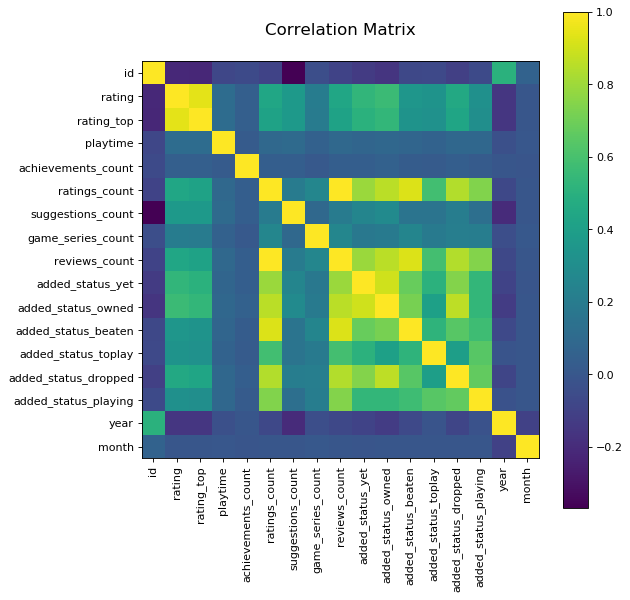

In [16]:
plotCorrelationMatrix(df, 8)

To analyze our dataset, we'll try to find out which features gives us more information of 'added_status_owned', which can be used as a measure of game sales.

Thus we have'rating' & 'rating_top' which are moderately correlated with 'added_status_owned'. As can be seen, there's a big colinearity between 'rating' and 'rating_top' so we will use only the first one.

This same principle can be used with features such as 'added_status_beaten', 'added_status_dropped', 'reviews_count', 'suggestions_count', 'game_series_count'.

In [17]:
# def corrfunc(x, y, **kws):
#     (r, p) = pearsonr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f} ".format(r),
#                 xy=(.1, .9), xycoords=ax.transAxes)
#     ax.annotate("p = {:.3f}".format(p),
#                 xy=(.4, .9), xycoords=ax.transAxes)

# matplotlib.rcParams["font.size"] = 16

# graph = sns.pairplot(df, x_vars=["added_status_beaten", "added_status_dropped", \
#                               "reviews_count", "rating", "suggestions_count", \
#                               "game_series_count"], y_vars=["added_status_owned"], height=5, aspect=.8, kind="reg");
# graph.map(corrfunc)
# plt.show()

In [18]:
# df['logadded_status_beaten'] = np.log(df[['added_status_beaten']] + 1)
# df['logadded_status_dropped'] = np.log(df[['added_status_dropped']] + 1)
# df['logadded_status_owned'] = np.log(df[['added_status_owned']] + 1)
# df['log_rating'] = np.log(df[['rating']] + 1)
# df['log_suggestions_count'] = np.log(df[['suggestions_count']] + 1)
# df['log_game_series_count'] = np.log(df[['game_series_count']] + 1)
# df['logreviews_count'] = np.log(df[['reviews_count']] + 1)

It becomes apparent that some of the relationships shown above exhibits a cone-shaped pattern. This makes sense as instances where there's only a single review with a high rating happens often which pulls our line downwards heavily. Let's log transform these variables to see if it fixes some of the problems.

In [19]:
# graph = sns.pairplot(df, x_vars=["logadded_status_beaten", "logadded_status_dropped", \
#                               "logreviews_count", "log_rating", "suggestions_count", \
#                               "log_game_series_count"], y_vars=["logadded_status_owned"], height=5, aspect=.8, kind="reg")
# graph.map(corrfunc)
# plt.show()

# Global Status: Single-label categorical variables

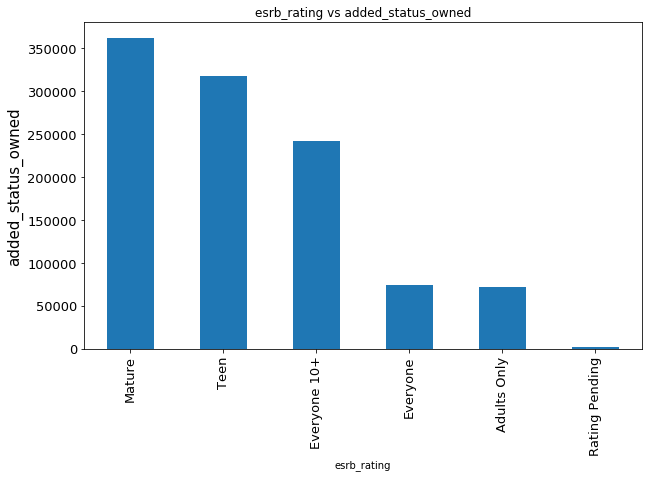

In [20]:
categorical_eval(df, 'esrb_rating')

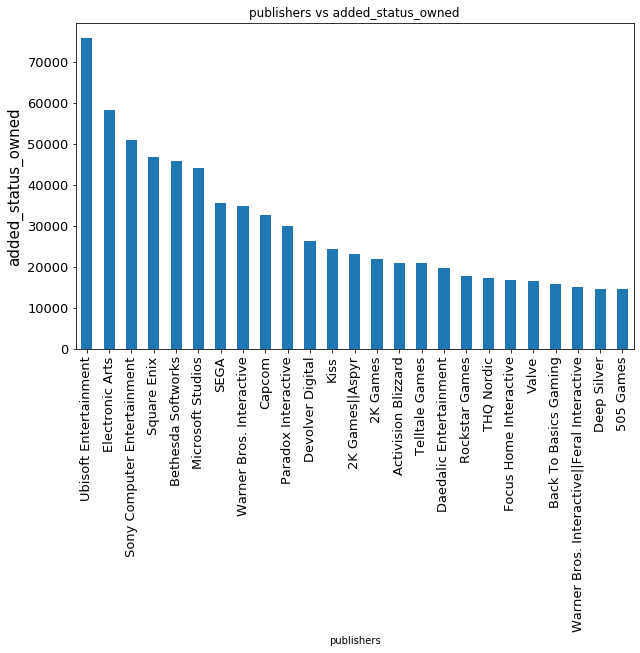

In [21]:
categorical_eval(df, 'publishers')

# Global Status: Multi-label categorical variables

There are 369401 rows and 26 columns


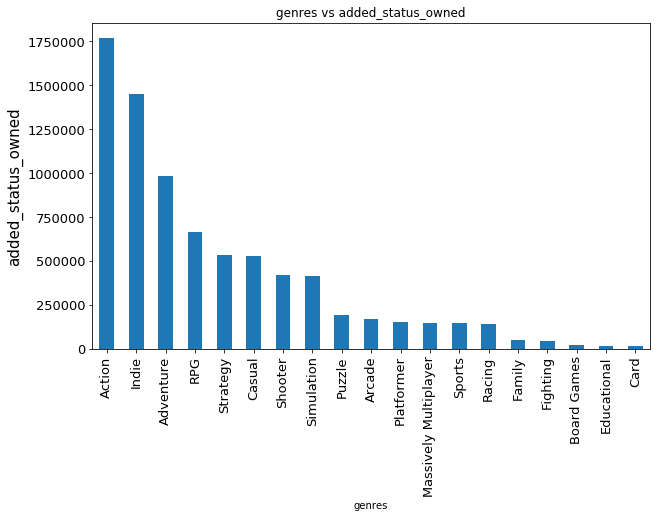

In [22]:
df = stack_column(df,'genres',sep='\||\.')
categorical_eval(df, 'genres')

There are 521460 rows and 26 columns


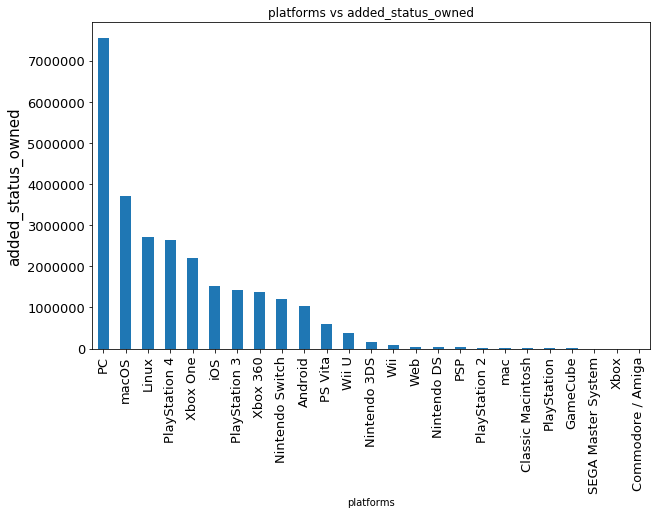

In [23]:
df = stack_column(df,'platforms',sep='\||\.')
categorical_eval(df, 'platforms')

There are 675362 rows and 26 columns


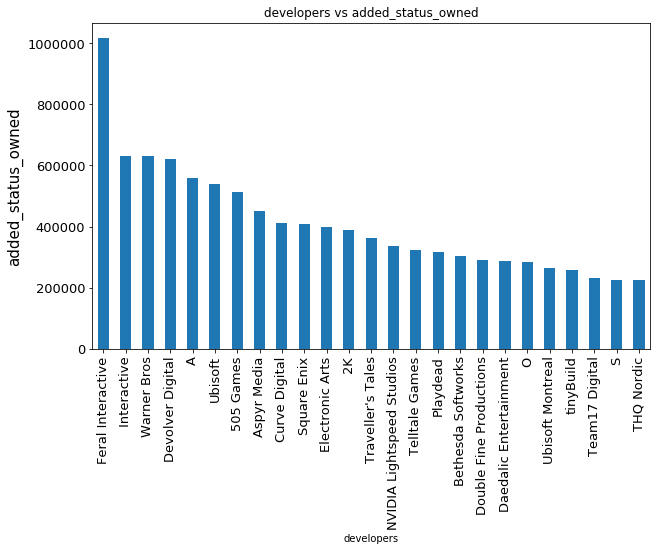

In [24]:
df = stack_column(df,'developers',sep='\||\.')
categorical_eval(df, 'developers')

There are 669589 rows and 26 columns


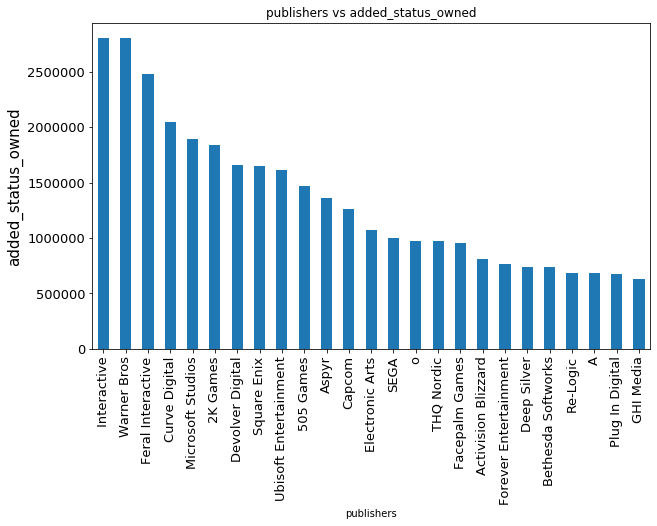

In [25]:
df = stack_column(df,'publishers',sep='\||\.')
categorical_eval(df, 'publishers')